# Case Study

<h2> Scenario: Few Shot Learning </h2> 

Points and assumptions worth considering:

- The proposed scenario does not follow the standard Few Shot Learning (FSL) approach. The standard FSL scenario contains training classes that are disjoint from the support set classes. 

- In this case, training, validation and test set contain the same classes.

- Due to data scarcity, finetuning with a standard classification approach (an additional layer on top of a CNN employed as a feature extractor) will not yield good results.

- The proposed approach consists of an episodic training methodology used in FSL.

- Common practices define a validation split taken from the training set. In this case, the training set is very limited, therefore a validation set was taken from the test set.

- In this notebook, a comparison between Prompt Engineering with CLIP, ResNet pre-trained in ImageNet and ViT from CLIP is presented.

<h2> Simplest solution: Zero Shot Prediction by Prompt Engineering from CLIP </h2>

CLIP employs natural language supervision and a contrastive loss to learn rich representations of images. As it is proposed in the original paper, we can predict "unseen" classes without any fine-tuning. Rather we can use prompt-engineering.

In [1]:
# Naive Approach with Prompt Engineering from CLIP

import torch
import clip
from PIL import Image
import os
from tqdm import tqdm
import numpy as np


print ("\n ---- ZERO SHOT CLIP BASED CLASSIFIER ----\n")

device = "cuda" if torch.cuda.is_available() else "cpu"
print ("Running on: ", device)
model, preprocess = clip.load("ViT-B/16", device=device)

data_path = './data/coco_crops_few_shot/test/'
classes = os.listdir(data_path)
class2idx = {elem:idx for idx, elem in enumerate(classes)}
print("Classes: ", classes)

# Compute Text Inputs (Classes) by generating prompts
with torch.no_grad():
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

corrects = {}
num_samples_per_class = {}

with torch.no_grad():
    for obj_class in tqdm(classes):
        img_list = os.listdir(data_path + obj_class)
        num_samples_per_class[obj_class] = len(img_list)
        corrects[obj_class] = 0

        for image in img_list:
            # Prepare the inputs
            image_path = os.path.join(data_path, obj_class, image)
            image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

            logits_per_image, logits_per_text = model(image, text_inputs)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

            pred_index = np.argmax(probs)
            if pred_index == class2idx[obj_class]:
                corrects[obj_class] += 1

# print("Label probs:", probs)  
print("\nAccuracy per class: ")
acc_per_class = {}
total_corrects = 0
total_samples = 0
for k,v in num_samples_per_class.items():
    acc_per_class[k] = corrects[k] / v
    total_corrects += corrects[k]
    total_samples += v

print(acc_per_class)
print("\nFinal Accuracy: ", (total_corrects/total_samples))


 ---- ZERO SHOT CLIP BASED CLASSIFIER ----

Running on:  cuda
Classes:  ['train', 'bus', 'bicycle', 'motorcycle', 'car', 'truck', 'boat', 'airplane']


100%|██████████| 8/8 [01:22<00:00, 10.27s/it]


Accuracy per class: 
{'train': 0.9473684210526315, 'bus': 0.9322033898305084, 'bicycle': 0.9722222222222222, 'motorcycle': 0.9772727272727273, 'car': 0.7297297297297297, 'truck': 0.7605633802816901, 'boat': 0.927536231884058, 'airplane': 1.0}

Final Accuracy:  0.9030732860520094


Simple by employing prompt engineering with the original CLIP model, an accuracy of 90.31% is achieved. Let's see if other approaches can improve this initial result.

<h2> FSL Episodic Training by Fine-Tuning an ImageNet pretrained ResNet </h2>

In this approach, we want to evaluate all the classes, therefore we set up a C-way K-shot that includes all the classes in the provided dataset (C=8, K=5).
- The episode will be a 8-way 5-shot with 5 additional samples as queries per class.
- The pipeline will be similar in all cases, the only changing component will be the backbone employed.
- The final representation of each image will be a vector of 64-d.
- The FSL approach employed is taken from the paper:
  Snell, Jake, Kevin Swersky, and Richard S. Zemel. "Prototypical networks for few-shot learning." arXiv preprint     arXiv:1703.05175 (2017).
- A centroid of each class is calculated (Prototype) and the distance between the query and the Prototype is used to label the query class.
- The loss function employed is Cross-Entropy, given by:


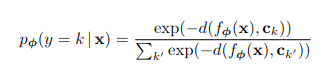

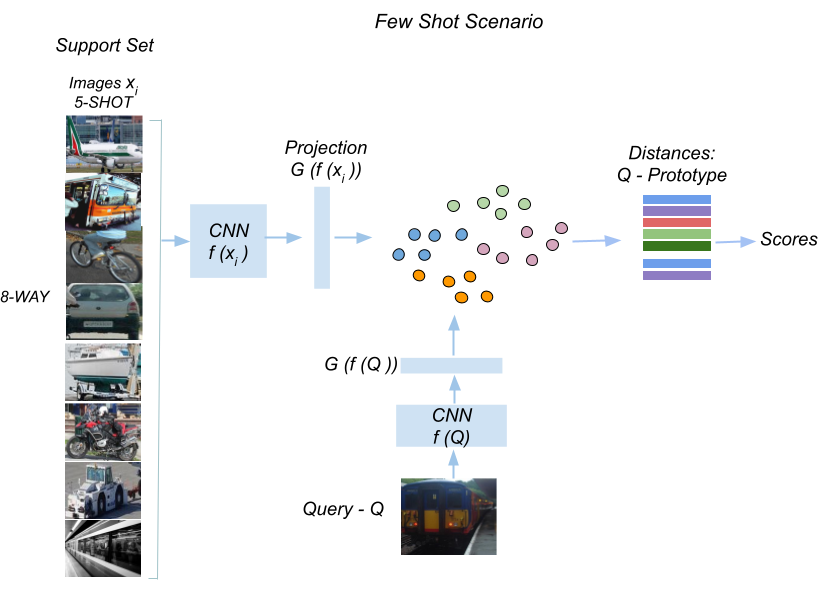

In this FSL approach a Prototypical Network is used. Other approaches could be: 
- Matching Networks - Vinyals, Oriol, et al. "Matching networks for one shot learning." Advances in neural information processing systems 29 (2016): 3630-3638 

- Relational Networks - Sung, Flood, et al. "Learning to compare: Relation network for few-shot learning." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.

- MAML - Finn, Chelsea, Pieter Abbeel, and Sergey Levine. "Model-agnostic meta-learning for fast adaptation of deep networks." International Conference on Machine Learning. PMLR, 2017


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import torch.nn.functional as F
from utils.data_tools import TaskSampler, EasySet
from utils.utils import sliding_average
import json
from matplotlib import pyplot as plt
import torchvision

%matplotlib inline

# Creates a Set for FSL
train_set = EasySet("/SSD/Helsing/data/train.json", image_size = 224, training=True)
test_set = EasySet("/SSD/Helsing/data/test.json", image_size = 224, training=False)
val_set = EasySet("/SSD/Helsing/data/val.json", image_size = 224, training=False)

print("Total Training Images: ", len(train_set.images))
print("Total Validation Images: ", len(val_set.images))
print("Total Testing Images: ", len(test_set.images))

Total Training Images:  234
Total Validation Images:  80
Total Testing Images:  423


In [32]:
# FSL Method used: Prototypes

class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        
        self.bn1 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 64)
        

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
#         import pdb; pdb.set_trace()
        z_support = F.relu(self.fc1(self.bn1(z_support)))
        z_query = F.relu(self.fc1(self.bn1(z_query)))
        
        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat([z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)])

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # Distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
for param in convolutional_network.parameters():
    param.requires_grad = False
convolutional_network.fc = nn.Flatten()

model = PrototypicalNetworks(convolutional_network).cuda()
print("Model Created")

Model Created


In [3]:
N_WAY = 8 # Number of classes in a task
K_SHOT = 5 # Number of images per class in the support set
N_QUERY = 5 # Number of images per class in the query set
N_EVALUATION_TASKS = 100 # Usually this number is bigger, but due to time constrains I set it to 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
# test_set.labels = [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


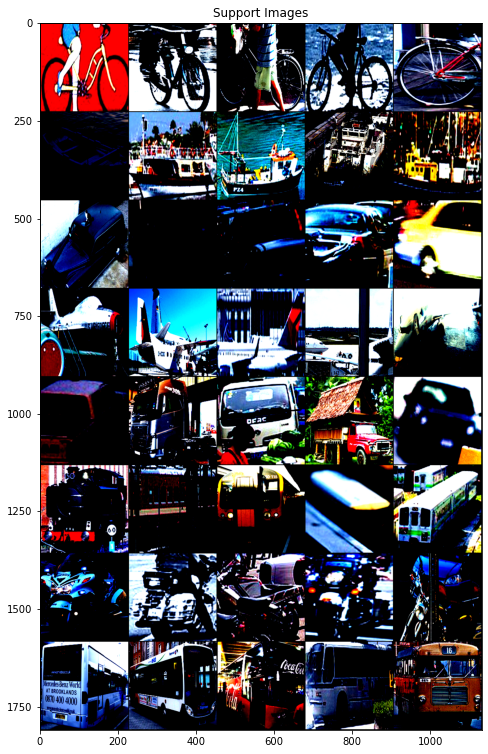

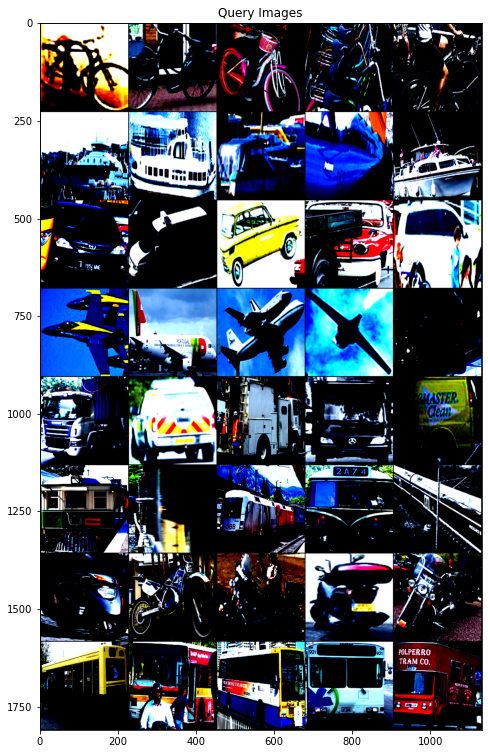

In [4]:
# VISUALIZE SOME TEST SET SAMPLES IN AN EPISODE

def plot_images(images: torch.Tensor, title: str, images_per_row: int):
    """
    Plot images in a grid.
    Args:
        images: 4D mini-batch Tensor of shape (B x C x H x W)
        title: title of the figure to plot
        images_per_row: number of images in each row of the grid
    """
#     plt.rcParams["figure.figsize"] = 500, 500
    plt.figure()
    
    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

plt.rcParams['figure.figsize'] = [10, 13]

# SHOW SAMPLES
(example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids) = next(iter(test_loader))


plot_images(example_support_images, "Support Images", images_per_row=K_SHOT)
plot_images(example_query_images, "Query Images", images_per_row=N_QUERY)



We can see the starting classification performance of the untrained ResNet with an added non-linear layer.

In [5]:
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(),
                       example_query_images.cuda()).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.class_names[example_class_ids[example_query_labels[i]]]} / {test_set.class_names[example_class_ids[example_predicted_labels[i]]]}"
    )


Ground Truth / Predicted
bicycle / motorcycle
bicycle / bicycle
bicycle / bicycle
bicycle / train
bicycle / bicycle
boat / boat
boat / boat
boat / truck
boat / truck
boat / boat
car / car
car / truck
car / car
car / car
car / truck
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
truck / truck
truck / truck
truck / truck
truck / car
truck / truck
train / bus
train / airplane
train / train
train / truck
train / train
motorcycle / motorcycle
motorcycle / bicycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
bus / bus
bus / bus
bus / bus
bus / bus
bus / bus


As we can see on the previous cell, the randomly initialized non-linearity introduced to the ResNet breaks the learned space. Let's calculate the performance.

In [6]:
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data,1,)[1]
        == query_labels.cuda()).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
#         ) in tqdm(enumerate(data_loader), total=len(data_loader)):
        ) in enumerate(data_loader):

            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return correct_predictions/total_predictions * 100


accuracy = evaluate(test_loader)


Model tested on 100 tasks. Accuracy: 61.70%


The initial model performs quite low in this setting. 
Differently than standard classification, we can interpret the task of FSL as given a queried image, that the model learns to point to a class from the support set to which the query most likely belongs.

In [7]:
# EPISODIC TRAINING 

N_TRAINING_EPISODES = 10000


# train_set.labels = [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# We use CE Loss to aprox the GT distribution to the pointing FSL mechanism.
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.00001)


def fit(support_images, support_labels, query_images, query_labels):
    """
    Args:
        Torch.tensor
    Returns:
        loss as float
    """
    optimizer.zero_grad()
    classification_scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [8]:
# CREATE VAL DATALOADER AND SAMPLER

val_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

val_loader = DataLoader(test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn)


In [9]:
# Train the model 

log_update_frequency = 10
val_episode = 500
best_accuracy = 0

all_loss = []
model.train()

with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _ ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
        
        if episode_index % val_episode == 0 and episode_index != 0:
            accuracy = evaluate(val_loader) 
            tqdm_train.set_postfix(acc=accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), "./models/resnet18_relu64d_8way5shot5query.pt") 
                

  5%|▌         | 500/10000 [00:57<10:12, 15.50it/s, acc=66.3] 

Model tested on 100 tasks. Accuracy: 66.28%


 10%|█         | 1001/10000 [01:37<2:35:46,  1.04s/it, acc=70.7]

Model tested on 100 tasks. Accuracy: 70.72%


 15%|█▌        | 1500/10000 [02:18<08:44, 16.21it/s, acc=72.4]  

Model tested on 100 tasks. Accuracy: 72.38%


 20%|██        | 2001/10000 [03:00<2:37:24,  1.18s/it, acc=73.4]  

Model tested on 100 tasks. Accuracy: 73.40%


 25%|██▌       | 2501/10000 [03:42<2:41:00,  1.29s/it, acc=74.1]

Model tested on 100 tasks. Accuracy: 74.10%


 30%|███       | 3000/10000 [04:23<07:17, 16.00it/s, acc=76]    

Model tested on 100 tasks. Accuracy: 75.97%


 35%|███▌      | 3504/10000 [05:04<1:17:47,  1.39it/s, acc=75.3]

Model tested on 100 tasks. Accuracy: 75.35%


 40%|████      | 4000/10000 [05:45<07:19, 13.66it/s, acc=76.1]  

Model tested on 100 tasks. Accuracy: 76.15%


 45%|████▌     | 4504/10000 [06:26<1:08:02,  1.35it/s, acc=75.8]

Model tested on 100 tasks. Accuracy: 75.75%


 50%|█████     | 5004/10000 [07:07<1:01:27,  1.35it/s, acc=76.1]

Model tested on 100 tasks. Accuracy: 76.12%


 55%|█████▌    | 5505/10000 [07:48<54:30,  1.37it/s, acc=75.8]  

Model tested on 100 tasks. Accuracy: 75.80%


 60%|██████    | 6000/10000 [08:29<04:55, 13.53it/s, acc=76.8]  

Model tested on 100 tasks. Accuracy: 76.75%


 65%|██████▌   | 6504/10000 [09:10<49:15,  1.18it/s, acc=76]    

Model tested on 100 tasks. Accuracy: 76.05%


 70%|███████   | 7004/10000 [09:50<36:33,  1.37it/s, acc=76]    

Model tested on 100 tasks. Accuracy: 76.05%


 75%|███████▌  | 7504/10000 [10:32<31:40,  1.31it/s, acc=76.5]  

Model tested on 100 tasks. Accuracy: 76.50%


 80%|████████  | 8005/10000 [11:13<24:27,  1.36it/s, acc=75.5]  

Model tested on 100 tasks. Accuracy: 75.53%


 85%|████████▌ | 8504/10000 [11:54<18:21,  1.36it/s, acc=76.2]  

Model tested on 100 tasks. Accuracy: 76.25%


 90%|█████████ | 9005/10000 [12:35<12:08,  1.37it/s, acc=75.9]  

Model tested on 100 tasks. Accuracy: 75.95%


 95%|█████████▌| 9505/10000 [13:15<06:05,  1.35it/s, acc=76.5]  

Model tested on 100 tasks. Accuracy: 76.50%


100%|██████████| 10000/10000 [13:48<00:00, 12.07it/s, loss=0.315]


In [33]:
print("Final ImageNet finetuned ResNet18 accuracy")
model.load_state_dict(torch.load("./models/resnet18_relu64d_8way5shot5query.pt"))
evaluate(test_loader)


Final ImageNet finetuned ResNet18 accuracy
Model tested on 100 tasks. Accuracy: 74.60%


74.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth / Predicted
truck / truck
truck / boat
truck / truck
truck / truck
truck / truck
boat / boat
boat / boat
boat / boat
boat / boat
boat / boat
bicycle / bicycle
bicycle / motorcycle
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle
train / bus
train / train
train / airplane
train / bus
train / train
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
bus / bus
bus / truck
bus / train
bus / truck
bus / bus
car / car
car / truck
car / bus
car / car
car / airplane
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane


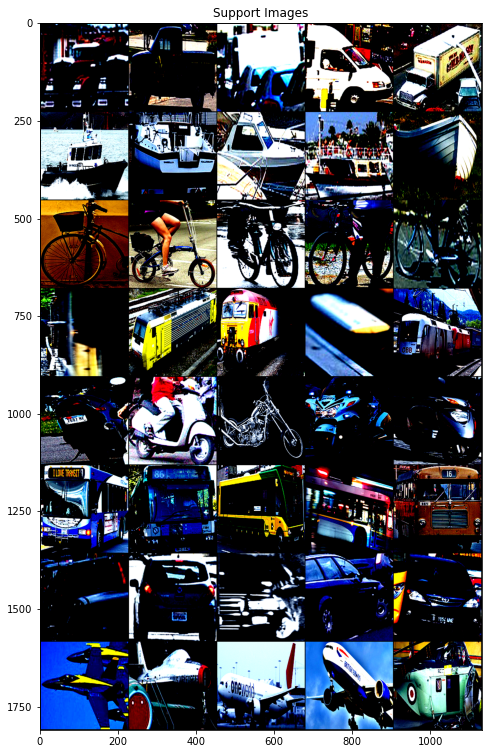

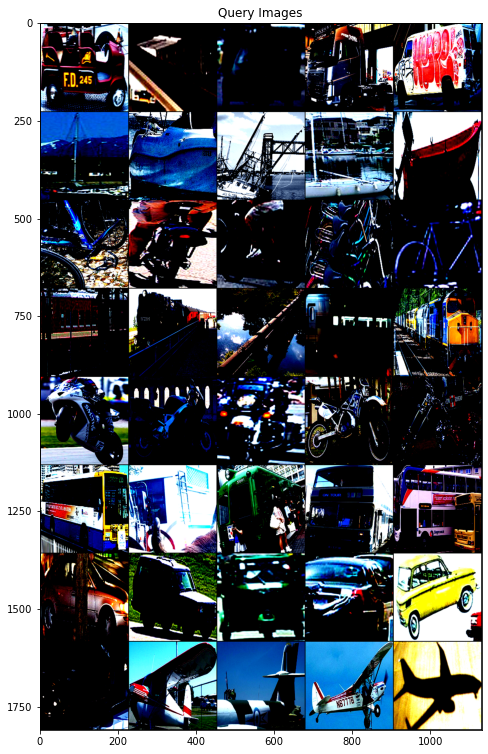

In [34]:
# SHOW SAMPLES
(example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids) = next(iter(test_loader))


plot_images(example_support_images, "Support Images", images_per_row=K_SHOT)
plot_images(example_query_images, "Query Images", images_per_row=N_QUERY)

model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(),
                       example_query_images.cuda()).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.class_names[example_class_ids[example_query_labels[i]]]} / {test_set.class_names[example_class_ids[example_predicted_labels[i]]]}"
    )


In [35]:
# ACC PER CLASS
import os

episodes = 50
model.eval()
class_names = os.listdir("./data/coco_crops_few_shot/test/")
accuracies = {class_name: {'total':0, 'correct':0} for class_name in class_names}

for episode in tqdm(range(episodes)):
    
    
    (example_support_images, example_support_labels, example_query_images, 
     example_query_labels, example_class_ids) = next(iter(test_loader))
        
    example_scores = model(example_support_images.cuda(), example_support_labels.cuda(),
                           example_query_images.cuda()).detach()

    _, example_predicted_labels = torch.max(example_scores.data, 1)

    for i in range(len(example_query_labels)):
             
        if test_set.class_names[example_class_ids[example_query_labels[i]]] == test_set.class_names[example_class_ids[example_predicted_labels[i]]]:
            accuracies[test_set.class_names[example_class_ids[example_predicted_labels[i]]]]['correct'] += 1
        accuracies[test_set.class_names[example_class_ids[example_predicted_labels[i]]]]['total'] +=1

print ("Accuracy per class: \n")
for k, v in accuracies.items():
    
    print("Accuracy per class {} is {:2f}%".format(k, (v['correct']/v['total']) * 100 ))


100%|██████████| 50/50 [01:37<00:00,  1.94s/it]

Accuracy per class: 

Accuracy per class train is 79.574468%
Accuracy per class bus is 64.444444%
Accuracy per class bicycle is 84.913793%
Accuracy per class motorcycle is 80.842912%
Accuracy per class car is 55.823293%
Accuracy per class truck is 47.272727%
Accuracy per class boat is 90.557940%
Accuracy per class airplane is 91.428571%


 - We can see that the accuracy performance improved about 15% points (from 61.7% 74.6%).
 - Also the predictions in per class are notably better.
 - The class truck is problematic as it has similar visual appeareance with bus and car classes.
 - However, the fine-tuned ResNet still yields worst results than a Zero shot prediction from CLIP by promp engineering. Let's see if we can improve the results.

<h2> FSL episodic evaluation with CLIP - pretrained ViT </h2>

In this approach, we want to evaluate all the classes, therefore we set up a C-way K-shot that includes all the classes in the provided dataset (C=8, K=5).
- The episode will be a 8-way 5-shot with 5 additional samples as queries per class.
- We employ the Image Encoder from CLIP as feature extractor. We learn a non-linearity on top of CLIP's encoder trained to solve the FSL task.



First, let's evaluate the original representations from CLIP and evaluate how they perform on FSL without performing Fine-Tuning.

In [12]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
import json
from utils.data_tools_clip import TaskSampler, EasySet
from utils.utils import sliding_average
from matplotlib import pyplot as plt
import torchvision
import clip

%matplotlib inline

# Generate the splits with a higher image size (CLIP inputs ResNet 384x384, ViT 224x224)

train_set = EasySet("./data/train.json", image_size = 224, training=True)
test_set = EasySet("./data/test.json", image_size = 224, training=False)
val_set = EasySet("./data/val.json", image_size = 224, training=False)

In [13]:
# Prototypical Network with ResNet pretrained from CLIP as backbone

class PrototypicalNetworks(nn.Module):
    def __init__(self, model_clip):
        super(PrototypicalNetworks, self).__init__()
        self.model_clip = model_clip
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """

        z_support = self.model_clip.encode_image(support_images.float())
        z_query = self.model_clip.encode_image(query_images.float())
        
        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat([z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)])

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # Distances into classification scores!
        scores = -dists
        return scores

        
device = "cuda" if torch.cuda.is_available() else "cpu"

# model_clip, preprocess = clip.load("RN50x16", device=device) 
model_clip, preprocess = clip.load("ViT-B/16", device=device) 
for param in model_clip.parameters():
    param.requires_grad = False

model = PrototypicalNetworks(model_clip).cuda()
print("Model Created... Running on: ", device)

Model Created... Running on:  cuda


In [14]:
N_WAY = 8 # Number of classes in a task
K_SHOT = 5 # Number of images per class in the support set
N_QUERY = 5 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
# test_set.labels = [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [15]:
def plot_images(images: torch.Tensor, title: str, images_per_row: int):
    """
    Plot images in a grid.
    Args:
        images: 4D mini-batch Tensor of shape (B x C x H x W)
        title: title of the figure to plot
        images_per_row: number of images in each row of the grid
    """
#     plt.rcParams["figure.figsize"] = 500, 500
    plt.figure()
    
    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

plt.rcParams['figure.figsize'] = [10, 13]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth / Predicted
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
car / motorcycle
car / car
car / car
car / car
car / car
boat / truck
boat / boat
boat / boat
boat / boat
boat / boat
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
train / train
train / train
train / train
train / truck
train / train
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle
bus / bus
bus / bus
bus / bus
bus / bus
bus / bus
truck / truck
truck / truck
truck / truck
truck / truck
truck / car


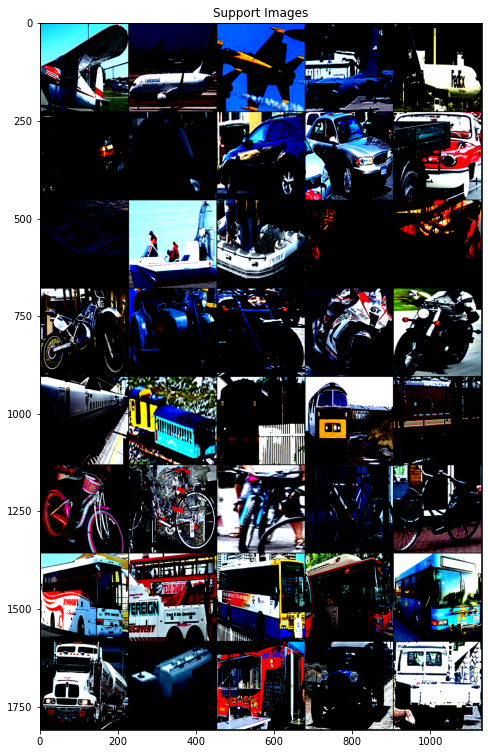

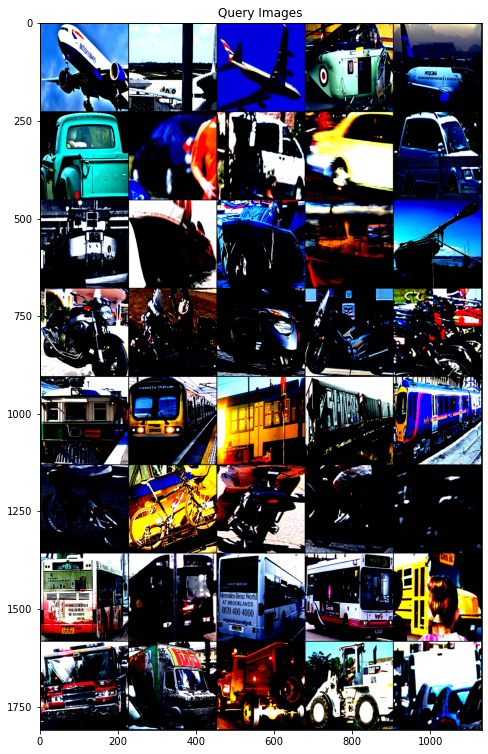

In [16]:
# SHOW SAMPLES
(example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids) = next(iter(test_loader))


plot_images(example_support_images, "Support Images", images_per_row=K_SHOT)
plot_images(example_query_images, "Query Images", images_per_row=N_QUERY)

model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(),
                       example_query_images.cuda()).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.class_names[example_class_ids[example_query_labels[i]]]} / {test_set.class_names[example_class_ids[example_predicted_labels[i]]]}"
    )

In [17]:
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data,1,)[1]
        == query_labels.cuda()).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):
#         ) in enumerate(data_loader):

            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return correct_predictions/total_predictions * 100


accuracy = evaluate(test_loader)


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]

Model tested on 100 tasks. Accuracy: 84.10%


CLIP raw representations are way stronger than a finetuned ResNet pre-trained on ImageNet. Evaluating CLIP with an episodic FSL setting, the performance achieved in 100 episodes is 84.10%.
Language provides a stronger supervision signal rich of attributes rather than a single label in standrad classification scenarios.
 

<h2> FSL Episodic Training by Fine-Tuning an CLIP pretrained ViT/16 </h2>

In this section, a fully connected layer will be added on top of the representations learned from the image encoder from CLIP. A Linear probe will try to improve the representations learned from the backbone specific to this dataset.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
import json
from utils.data_tools_clip import TaskSampler, EasySet
from utils.utils import sliding_average
from matplotlib import pyplot as plt
import torchvision
import clip

%matplotlib inline

# Generate the splits with a higher image size (CLIP input 384x384)

train_set = EasySet("./data/train.json", image_size = 224, training=True)
test_set = EasySet("./data/test.json", image_size = 224, training=False)
val_set = EasySet("./data/val.json", image_size = 224, training=False)

In [2]:
# Prototypical Network with ViT/16 pretrained from CLIP as backbone

class PrototypicalNetworks(nn.Module):
    def __init__(self, model_clip):
        super(PrototypicalNetworks, self).__init__()
        self.model_clip = model_clip
        
        self.bn1 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 64)
               

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """

        z_support = self.model_clip.encode_image(support_images)
        z_query = self.model_clip.encode_image(query_images)
        
        z_support = F.relu(self.fc1(self.bn1(z_support.float())))
        z_query = F.relu(self.fc1(self.bn1(z_query.float())))

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat([z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)])

        # Compute the euclidean distance from queries to prototypes
                                          
        dists = torch.cdist(z_query, z_proto)
 
        # Distances into classification scores
        scores = -dists
        return scores

        
device = "cuda" if torch.cuda.is_available() else "cpu"

# model_clip, preprocess = clip.load("RN50x16", device=device) 
model_clip, preprocess = clip.load("ViT-B/16", device=device) 
for param in model_clip.parameters():
    param.requires_grad = False

model = PrototypicalNetworks(model_clip).cuda()
print("Model Created... Running on: ", device)

Model Created... Running on:  cuda


In [3]:
N_WAY = 8 # Number of classes in a task
K_SHOT = 5 # Number of images per class in the support set
N_QUERY = 5 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
# test_set.labels = [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [4]:
# VISUALIZE SOME TEST SET SAMPLES IN AN EPISODE

def plot_images(images: torch.Tensor, title: str, images_per_row: int):
    """
    Plot images in a grid.
    Args:
        images: 4D mini-batch Tensor of shape (B x C x H x W)
        title: title of the figure to plot
        images_per_row: number of images in each row of the grid
    """
#     plt.rcParams["figure.figsize"] = 500, 500
    plt.figure()
    
    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

plt.rcParams['figure.figsize'] = [10, 13]


In [5]:
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data,1,)[1]
        == query_labels.cuda()).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
#         ) in tqdm(enumerate(data_loader), total=len(data_loader)):
        ) in enumerate(data_loader):

            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return correct_predictions/total_predictions * 100


In [6]:
# EPISODIC TRAINING


N_TRAINING_EPISODES = 10000


# train_set.labels = [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

def fit(support_images, support_labels, query_images, query_labels):
    """
    Args:
        Torch.tensor
    Returns:
        loss as float
    """
    optimizer.zero_grad()
    classification_scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [7]:
# TODO: CREATE VAL LOADER
val_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

val_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [8]:
# Train the model 

log_update_frequency = 10
val_episode = 1000
best_accuracy = 0


all_loss = []
model.train()


with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _ ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
        
        if episode_index % val_episode == 0 and episode_index != 0:
            accuracy = evaluate(val_loader) 
            tqdm_train.set_postfix(acc=accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), "./models/clip_ViT16_softmax64d_8way5shot5query.pt") 
                

 10%|█         | 1000/10000 [07:49<1:02:11,  2.41it/s, acc=90.8]  

Model tested on 100 tasks. Accuracy: 90.80%


 20%|██        | 2001/10000 [15:36<30:27:40, 13.71s/it, acc=90.4]  

Model tested on 100 tasks. Accuracy: 90.42%


 30%|███       | 3001/10000 [23:24<26:47:41, 13.78s/it, acc=89.6] 

Model tested on 100 tasks. Accuracy: 89.65%


 40%|████      | 4001/10000 [31:11<22:47:07, 13.67s/it, acc=90.1] 

Model tested on 100 tasks. Accuracy: 90.10%


 50%|█████     | 5001/10000 [38:59<19:07:49, 13.78s/it, acc=90.4]  

Model tested on 100 tasks. Accuracy: 90.38%


 60%|██████    | 6001/10000 [46:44<15:10:07, 13.66s/it, acc=90.2]  

Model tested on 100 tasks. Accuracy: 90.25%


 70%|███████   | 7001/10000 [54:29<11:23:26, 13.67s/it, acc=89.2]  

Model tested on 100 tasks. Accuracy: 89.25%


 80%|████████  | 8001/10000 [1:02:17<7:38:43, 13.77s/it, acc=88.6] 

Model tested on 100 tasks. Accuracy: 88.60%


 90%|█████████ | 9001/10000 [1:10:05<3:49:06, 13.76s/it, acc=88.5] 

Model tested on 100 tasks. Accuracy: 88.47%


100%|██████████| 10000/10000 [1:17:08<00:00,  2.16it/s, loss=0.0389]


In [9]:
model.load_state_dict(torch.load("./models/clip_ViT16_softmax64d_8way5shot5query.pt"))
evaluate(test_loader)

Model tested on 100 tasks. Accuracy: 91.28%


91.27499999999999

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth / Predicted
bus / bus
bus / bus
bus / bus
bus / bus
bus / bus
train / train
train / bus
train / train
train / train
train / train
truck / truck
truck / truck
truck / truck
truck / motorcycle
truck / truck
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
airplane / airplane
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
motorcycle / motorcycle
car / truck
car / car
car / car
car / car
car / truck
boat / boat
boat / boat
boat / boat
boat / boat
boat / boat
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle
bicycle / bicycle


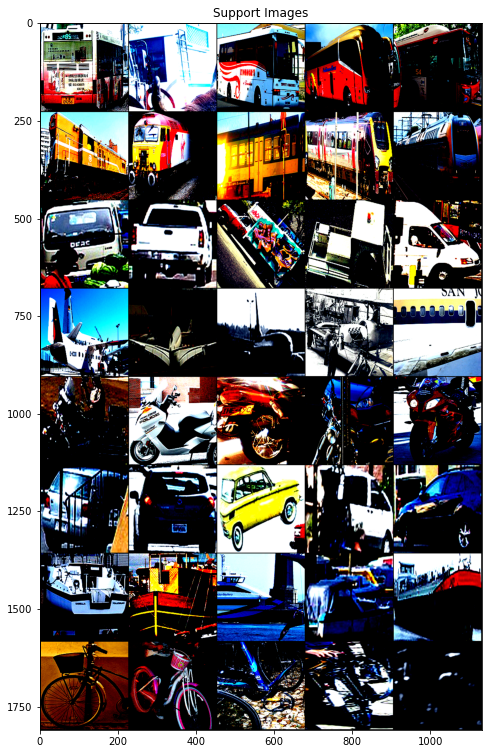

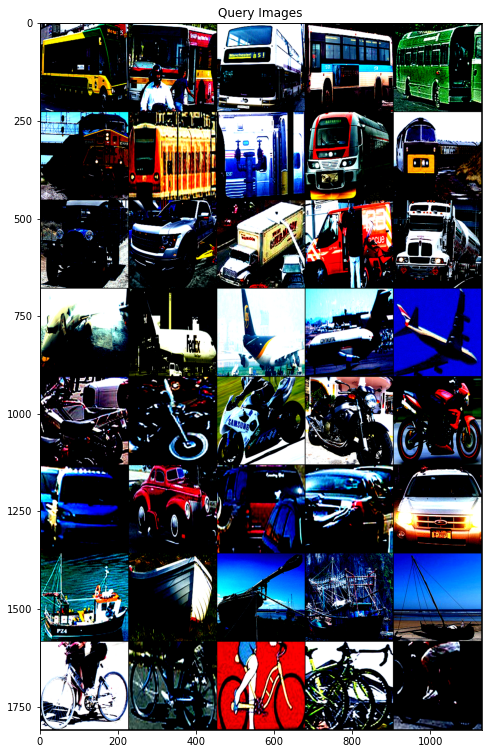

In [10]:
# VISUALIZE SOME SAMPLES
(example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids) = next(iter(test_loader))


plot_images(example_support_images, "Support Images", images_per_row=K_SHOT)
plot_images(example_query_images, "Query Images", images_per_row=N_QUERY)

model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(),
                       example_query_images.cuda()).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.class_names[example_class_ids[example_query_labels[i]]]} / {test_set.class_names[example_class_ids[example_predicted_labels[i]]]}"
    )


In [31]:
# ACC PER CLASS
import os

episodes = 50
model.eval()
class_names = os.listdir("./data/coco_crops_few_shot/test/")
accuracies = {class_name: {'total':0, 'correct':0} for class_name in class_names}

for episode in tqdm(range(episodes)):
    
    
    (example_support_images, example_support_labels, example_query_images, 
     example_query_labels, example_class_ids) = next(iter(test_loader))
        
    example_scores = model(example_support_images.cuda(), example_support_labels.cuda(),
                           example_query_images.cuda()).detach()

    _, example_predicted_labels = torch.max(example_scores.data, 1)

    for i in range(len(example_query_labels)):
             
        if test_set.class_names[example_class_ids[example_query_labels[i]]] == test_set.class_names[example_class_ids[example_predicted_labels[i]]]:
            accuracies[test_set.class_names[example_class_ids[example_predicted_labels[i]]]]['correct'] += 1
        accuracies[test_set.class_names[example_class_ids[example_predicted_labels[i]]]]['total'] +=1

print ("Accuracy per class: \n")
for k, v in accuracies.items():
    
    print("Accuracy per class {} is {:2f}%".format(k, (v['correct']/v['total']) * 100 ))


100%|██████████| 50/50 [01:50<00:00,  2.21s/it]

Accuracy per class: 

Accuracy per class train is 99.148936%
Accuracy per class bus is 92.277992%
Accuracy per class bicycle is 94.186047%
Accuracy per class motorcycle is 96.047431%
Accuracy per class car is 87.142857%
Accuracy per class truck is 73.571429%
Accuracy per class boat is 100.000000%
Accuracy per class airplane is 98.039216%


<h3>Final Remarks </h3>

- As we can see, we have improved the representations learned by CLIP by adding a non linearity. We improved the original performance from 84.10% to 91.28%.
- Fine tuning CLIP on a FSL setting improved the accuracy for this toy dataset. The results even surpassed the previous explored scenarios such as prompt engineering, ResNet ImageNet and an original CLIP model.


# Zero Shot Learning

Two cases are explored. The first one in which there are no class labels at training time .The second case is an extension of the FSL, in which novel classes are not seen at traning time.

In the first case, we can create an autoencoder or VAE (Loss: KL Divergence + Reconctruction). On top of the latent space, a one class SVM can be used to detect novel classes. 

In the second case (extension of FSL) I propose two plausible models. 

<h3> Few Shot Learning + Zero Shot Novelty Detection - Proposed Model 1 </h3>

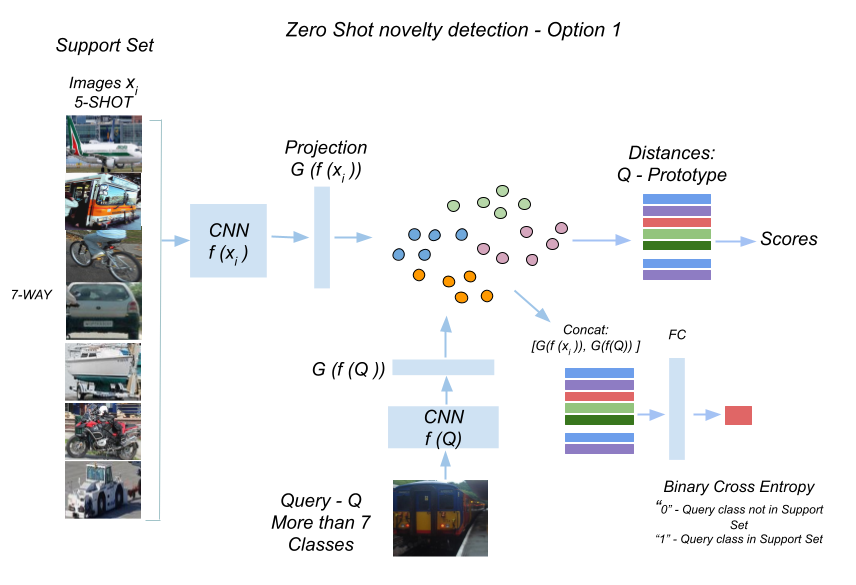

Model Explanation:
1) Reduce the 8-way to a 7-WAY 5-Shot scenario. <br>
2) The classes of the queries on each episode can be disjoint from the support set classes. <br>
3) A concatenation of visual features from the support set and query along dim=1 can be used as input into a non-linear layer. <br>
4) The non-Linear has to predict whether the queried class is present ("1) or not in the support set"0". <br>
5) A sigmoid followed by a Binary Cross Entropy Loss can be used to train this branch. <br>
6) A hyperparameter can be used to weight the Classification loss along with the Novelty classification Loss.


Cons:
- Careful sampling needs to be conducted of the class not contained in the support set.
- Might be tricky to train.


<h3> Few Shot Learning + Zero Shot Novelty Detection - Proposed Model 2 </h3>

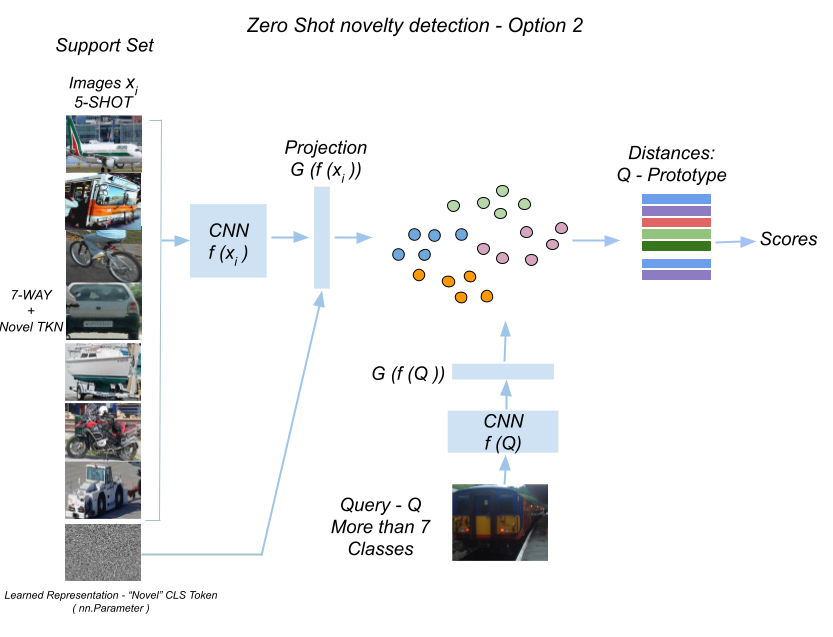

Model Explanation:
1) Reduce the 8-way to a 7-WAY 5-Shot scenario. <br>
2) The classes of the queries on each episode can be disjoint from the support set classes. <br>
3) In the support set, a learneable vector (Pytorch - nn.Parameter) can be learned to represent a novel class not present in the support set. Similar as learned tokens in DeTR or Language embedding tasks. <br>
4) The scores are computed as the previos FSL methodology, however the last score will represent whether a query's class is contained or not in the support set.<br>
5) Original Loss function can be used. 


Cons:
- In language tasks, significant data is usually required to learn useful representations.
- Similar effect is present in transfomers, due to the data hungry model.
- To experiment and see if this approach can work.